/Users/maikyon/anaconda3/envs/ml-312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/maikyon/anaconda3/envs/ml-312/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/maikyon/anaconda3/envs/ml-312/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/maikyon/anaconda3/envs/ml-312/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


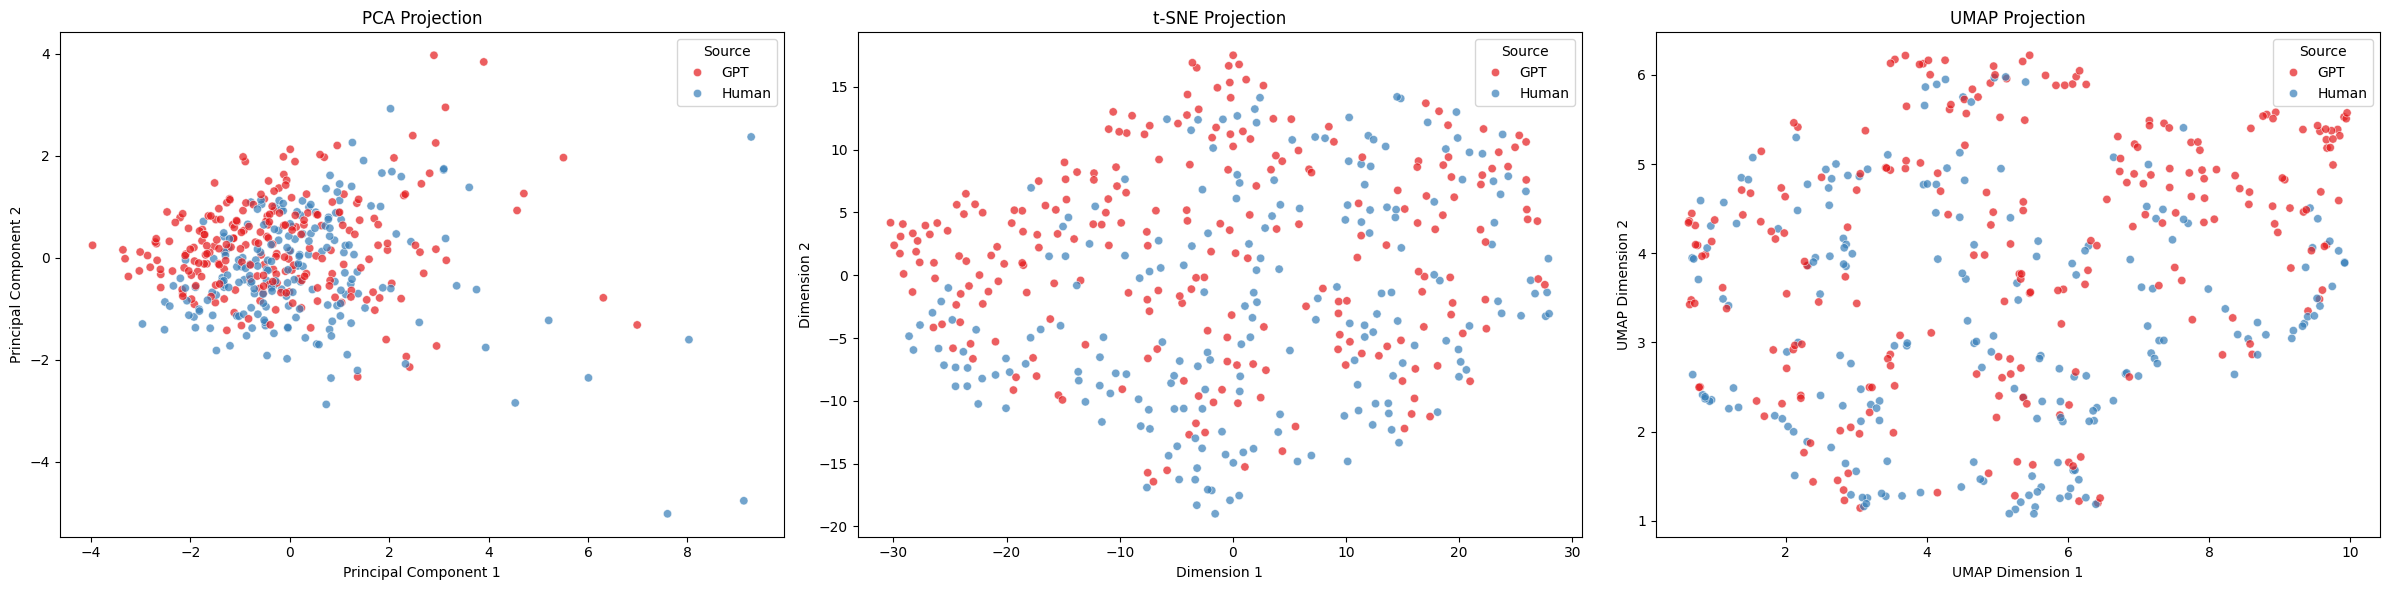

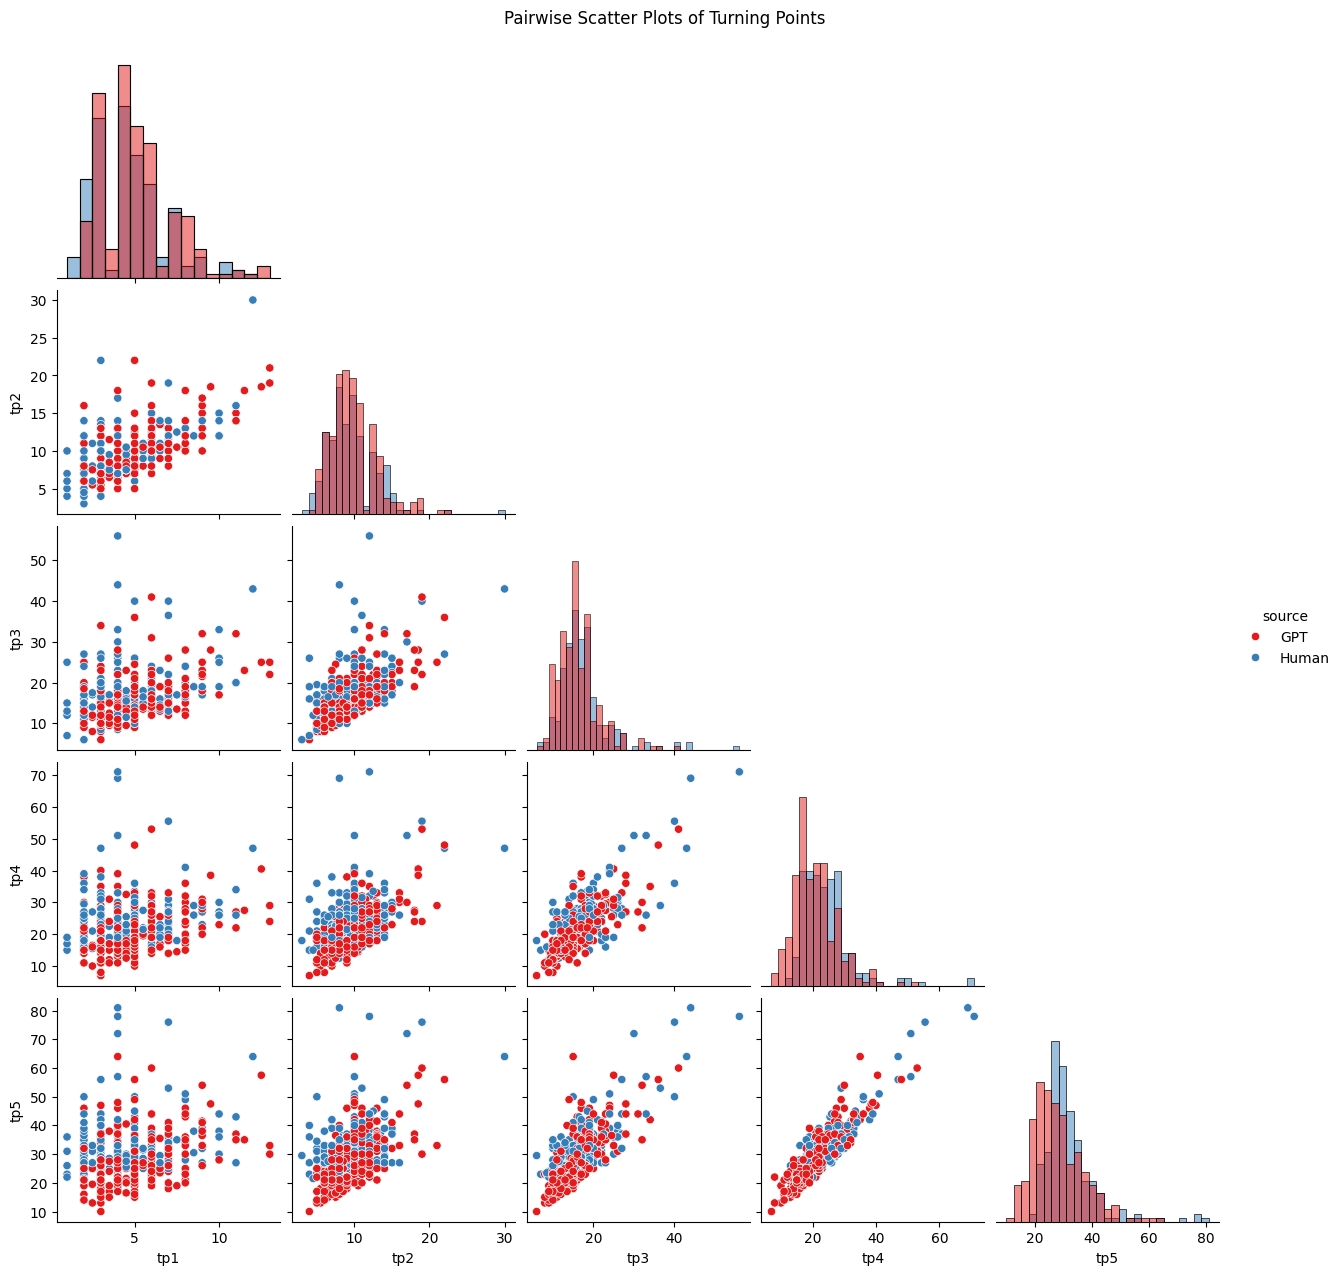

In [1]:
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Load the data
with open("../datasets/ground_truth.json", "r") as f:
    data = json.load(f)

# Extract turning points and arc labels
x_ds = []
y_ds = []

for narrative in data:
    # Get turning points as features
    tps = [
        narrative['turning_points'].get("tp1", 0),
        narrative['turning_points'].get("tp2", 0), 
        narrative['turning_points'].get("tp3", 0),
        narrative['turning_points'].get("tp4", 0),
        narrative['turning_points'].get("tp5", 0)
    ]
    x_ds.append(tps)
    
    # Get arc label
    y_ds.append(narrative.get("source", "Unknown"))  # Handle unknown sources if any

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(x_ds, columns=['tp1', 'tp2', 'tp3', 'tp4', 'tp5'])
df['source'] = y_ds

# Encode the 'source' labels to numerical values
le = LabelEncoder()
df['source_encoded'] = le.fit_transform(df['source'])

# Optionally, exclude 'Unknown' sources
df = df[df['source'] != 'Unknown']

# Features and labels
features = ['tp1', 'tp2', 'tp3', 'tp4', 'tp5']
X = df[features].values
y = df['source_encoded'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

# Create DataFrames for plotting
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Source'] = df['source']

df_tsne = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['Source'] = df['source']

df_umap = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Source'] = df['source']

# Plot all projections side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

sns.scatterplot(ax=axes[0], data=df_pca, x='PC1', y='PC2', hue='Source', palette='Set1', alpha=0.7)
axes[0].set_title('PCA Projection')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

sns.scatterplot(ax=axes[1], data=df_tsne, x='Dim1', y='Dim2', hue='Source', palette='Set1', alpha=0.7)
axes[1].set_title('t-SNE Projection')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')

sns.scatterplot(ax=axes[2], data=df_umap, x='UMAP1', y='UMAP2', hue='Source', palette='Set1', alpha=0.7)
axes[2].set_title('UMAP Projection')
axes[2].set_xlabel('UMAP Dimension 1')
axes[2].set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

# Optional: Pairwise Scatter Plots
sns.pairplot(df, vars=features, hue='source', palette='Set1', diag_kind='hist', corner=True)
plt.suptitle('Pairwise Scatter Plots of Turning Points', y=1.02)
plt.show()